# Multiple Variable Linear Regression

In [1]:
import copy
import math
from typing import Callable
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

### Housing price prediction

The training dataset contains three examples with four features (size, bedrooms, floors and, age) shown in the table below. The size is in sqft rather than 1000 sqft. 

| Size (sqft) | Number of Bedrooms | Number of floors | Age of  Home | Price (1000s dollars) |
|-------------|--------------------|------------------|--------------|-----------------------|
| 2104        | 5                  | 1                | 45           | 460                   |
| 1416        | 3                  | 2                | 40           | 232                   |
| 852         | 2                  | 1                | 35           | 178                   |

In [2]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])


## Matrix X containing our examples
Examples are stored in a NumPy matrix `X_train`. Each row of the matrix represents one example. The $m$ training examples, and there are $n$ features, $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).


$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  


In [3]:
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y Shape: (3,), y Type:<class 'numpy.ndarray'>)
[460 232 178]


## Parameter vector w, b

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

$\mathbf{w}$ and $b$ will be loaded with some initial selected values that are near the optimal. $\mathbf{w}$ is a 1-D NumPy vector.

In [4]:
b_init = 785.1811367994083
w_init = np.array([0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


# Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

## Single Prediction element by element
previous prediction multiplied one feature value by one parameter and added a bias parameter. A direct extension of our previous implementation of prediction to multiple features would be to implement (1) above using loop over each element, performing the multiply with its parameter and then adding the bias parameter at the end.


In [5]:
def predict_single_loop(x, w, b):
    """
    single predict using linear regression

    Args:
      x: example with multiple features
      w: model parameters
      b:  model parameter

    Returns:
      p:  prediction
    """
    n = x.shape[0]
    p = 0
    for i in range(n):
        p_i = x[i] * w[i]
        p = p + p_i
    p = p + b
    return p

In [6]:
x_vec = X_train[0, :]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.9999976194083


Note the shape of `x_vec`. It is a 1-D NumPy vector with 4 elements, (4,). The result, `f_wb` is a scalar.

## Single Prediction, vector

Noting that equation (1) above can be implemented using the dot product as in (2) above. We can make use of vector operations to speed up predictions.

In [7]:
def predict(x, w, b):
    """
    single predict using linear regression
    Args:
      x: Shape (n,) example with multiple features
      w: Shape (n,) model parameters
      b: model parameter

    Returns:
      p: prediction
    """
    p = np.dot(x, w) + b
    return p

In [8]:
# get a row from our training data
x_vec = X_train[0, :]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.9999976194083


# Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:

$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 

where:

$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


$\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [9]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X: Data, m examples with n features
      y: target values
      w: model parameters
      b: model parameter

    Returns:
      cost: cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost = cost + (f_wb_i - y[i]) ** 2
    cost = cost / (2 * m)
    return cost

In [10]:
# Compute and display cost using our pre-chosen optimal parameters.
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f"Cost at optimal w : {cost}")

Cost at optimal w : 1.5578904045996674e-12


# Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


## Compute Gradient with Multiple Variables
An implementation for calculating the equations (6) and (7) is below. There are many ways to implement this. In this version, there is an
- outer loop over all m examples. 
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ for the example can be computed directly and accumulated
    - in a second loop over all n features:
        - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ is computed for each $w_j$.
   

In [11]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      X: Data, m examples with n features
      y: target values
      w: model parameters
      b: model parameter

    Returns:
      dj_dw: The gradient of the cost w.r.t. the parameters w.
      dj_db:       The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.0

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [12]:
# Compute and display gradient
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f"dj_db at initial w,b: {tmp_dj_db}")
print(f"dj_dw at initial w,b: \n {tmp_dj_dw}")

dj_db at initial w,b: -1.6739251122999121e-06
dj_dw at initial w,b: 
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


## Gradient Descent With Multiple Variables

In [13]:
def gradient_descent(
    X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters
):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X: Data, m examples with n features
      y: target values
      w_in: initial model parameters
      b_in: initial model parameter
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha: Learning rate
      num_iters: number of iterations to run gradient descent

    Returns:
      w: Updated values of parameters
      b: Updated value of parameter
    """

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  # avoid modifying global w within function
    b = b_in

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w, b)  ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw  ##None
        b = b - alpha * dj_db  ##None

        # Save cost J at each iteration
        if i < 100000:  # prevent resource exhaustion
            J_history.append(cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")

    return w, b, J_history  # return final w,b and J history for graphing

In [14]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.0
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent
w_final, b_final, J_hist = gradient_descent(
    X_train,
    y_train,
    initial_w,
    initial_b,
    compute_cost,
    compute_gradient,
    alpha,
    iterations,
)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m, _ = X_train.shape
for i in range(m):
    print(
        f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}"
    )

Iteration    0: Cost  2529.46   
Iteration  100: Cost   695.99   
Iteration  200: Cost   694.92   
Iteration  300: Cost   693.86   
Iteration  400: Cost   692.81   
Iteration  500: Cost   691.77   
Iteration  600: Cost   690.73   
Iteration  700: Cost   689.71   
Iteration  800: Cost   688.70   
Iteration  900: Cost   687.69   
b,w found by gradient descent: -0.00,[ 0.2   0.   -0.01 -0.07] 
prediction: 426.19, target value: 460
prediction: 286.17, target value: 232
prediction: 171.47, target value: 178


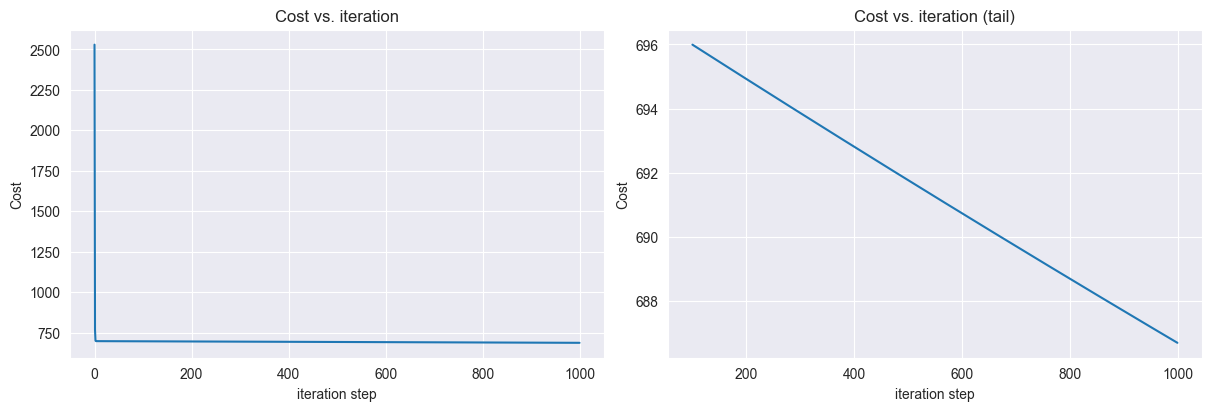

In [15]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration")
ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel("Cost")
ax2.set_ylabel("Cost")
ax1.set_xlabel("iteration step")
ax2.set_xlabel("iteration step")
plt.show()